In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/learning_ai'
sys.path.append(ROOT_PATH)

Mounted at /content/drive


## Auto Encoder

### tanhレイヤー

In [2]:
class Tanh:
    def __init__(self):
        self.params,self.grads=[],[]
        self.out=None

    def forward(self,x):
        out=np.tanh(x)
        self.out=out
        # print(out)
        return out

    def backward(self,dout):
        dx=dout*(1.0-self.out)**2
        # print(dx)
        return dx

### 平均２乗誤差　MSE



In [3]:
class MSE:
    def __init__(self):
        self.cache=None
        self.params,self.grads=[],[]

    def forward(self,x,t):
        batch_size=x.shape[0]
        loss=0.5*np.sum((x-t)**2)/batch_size
        self.cache=(x,t)
        return loss

    def backward(self,dout=1):
        x,t=self.cache
        batch_size=x.shape[0]
        dout/=batch_size
        dx=dout*(x-t)
        return dx

### KLDivergence

2つの確率分布の「差異」を計る尺度として用いる

$$
{\begin{align}
{\rm KL}[q(x)||p(x)] &= q(x)\ln\frac{p(x)}{q(x)}\\
&=q(x)\ln p(x) - q(x)\ln q(x)
\end{align}
}
$$

KL divergenceは「交差エントロピー - エントロピー」

* エントロピー・・ある確率分布の予測のしにくさ  
* 交差エントロピー・・ある確率分布を仮定して生成された、別の確率分布の予測のしにくさ  
常に「交差エントロピー ≧ エントロピー」なので、KL divergenceは必ず非負値になる

### relu+SGD

In [2]:
class AE1:
    def __init__(self,input_size=784,hidden_size=2,output_size=784):    

        self.layers=[Affine((input_size,),[hidden_size,2.]),
                     Relu((hidden_size,),[]),
                     Affine((hidden_size,),[output_size,2.])]
        self.loss_layer=MSE()

        self.params,self.grads=[],[]

        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,x):
        for layer in self.layers:
            x=layer.forward(x)
        return x

    def forward(self,x,t):
        y=self.predict(x)
        loss=self.loss_layer.forward(y,t)
        return loss

    def backward(self,dout=1):
        dx=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dx=layer.backward(dx)
        return dx

    def generate(self,x):
        y=self.layers[2].forward(x)
        y=y.reshape(28,28)
        return y

In [3]:
from common import config
config.GPU=True
from common.np import *
from common.layer_dictionary import *
from common.layers import *
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

batch_size=100
max_epoch=20
lr=0.01
iter_per_epoch=int(x_train.shape[0]/batch_size)

epoch_cnt=0

model=AE1(input_size=784,hidden_size=2,output_size=784)
optimizer=SGD(lr)

train_loss_list=[]
total_loss=0
loss_cnt=0
for epoch in range(max_epoch):
    epoch_cnt+=1
    for iter in range(iter_per_epoch):
        batch_mask=np.arange(iter*batch_size,iter*batch_size+batch_size)
        x_batch=x_train[batch_mask]

        loss=model.forward(x_batch,x_batch)
        total_loss+=loss
        loss_cnt+=1

        dout=1
        model.backward(dout)
        optimizer.update(model.params,model.grads)

    average_loss=total_loss/loss_cnt
    print('loss:',average_loss)
    train_loss_list.append(average_loss)

loss: 26.713595860395465
loss: 25.49826971348937
loss: 24.910661253649053
loss: 24.562243778262584
loss: 24.330782383402198


KeyboardInterrupt: 

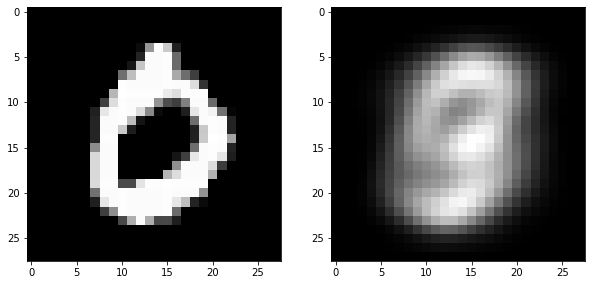

In [ ]:
import matplotlib.pyplot as plt

x=x_test[3]
y=model.predict(x)
x=to_cpu(x)
y=to_cpu(y)

x=x.reshape(28,28)
y=y.reshape(28,28)

fig,ax=plt.subplots(1,2,figsize=(10,20),facecolor='w')
ax[0].imshow(x,cmap='gray')
ax[1].imshow(y,cmap='gray')
fig.show()

### sigmoid+Adam

In [4]:
class AE2:
    def __init__(self,input_size=784,hidden_size=2,output_size=10): 

        self.layers=[Affine((input_size,),[hidden_size,1.]),
                     Sigmoid((hidden_size,),[]),
                     Affine((hidden_size,),[output_size,1.])]
        self.loss_layer=MSE()

        self.params,self.grads=[],[]

        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,x):
        for layer in self.layers:
            x=layer.forward(x)
        return x

    def forward(self,x,t):
        y=self.predict(x)
        loss=self.loss_layer.forward(y,t)
        return loss

    def backward(self,dout=1):
        dx=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dx=layer.backward(dx)
        return dx

    def generate(self,x):
        y=self.layers[2].forward(x)
        y=y.reshape(28,28)
        return y

In [5]:
from common import config
config.GPU=True
from common.np import *
from common.layer_dictionary import *
from common.layers import *
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

batch_size=100
max_epoch=20
lr=0.01
iter_per_epoch=int(x_train.shape[0]/batch_size)

epoch_cnt=0

model=AE2(input_size=784,hidden_size=2,output_size=784)
optimizer=Adam(lr)

train_loss_list=[]
total_loss=0
loss_cnt=0
for epoch in range(max_epoch):
    epoch_cnt+=1
    for iter in range(iter_per_epoch):
        batch_mask=np.arange(iter*batch_size,iter*batch_size+batch_size)
        x_batch=x_train[batch_mask]

        loss=model.forward(x_batch,x_batch)
        total_loss+=loss
        loss_cnt+=1

        dout=1
        model.backward(dout)
        optimizer.update(model.params,model.grads)

    average_loss=total_loss/loss_cnt
    print('loss:',average_loss)
    train_loss_list.append(average_loss)

loss: 24.361332210613657
loss: 23.62601167265545


KeyboardInterrupt: 

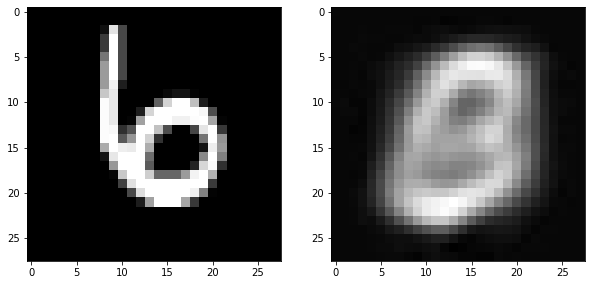

In [ ]:
import matplotlib.pyplot as plt

x=x_test[np.random.randint(len(x_test))]
y=model.predict(x)
x=to_cpu(x)
y=to_cpu(y)

x=x.reshape(28,28)
y=y.reshape(28,28)

fig,ax=plt.subplots(1,2,figsize=(10,20),facecolor='w')
plt.gray()
ax[0].imshow(x)
ax[1].imshow(y)
plt.show()

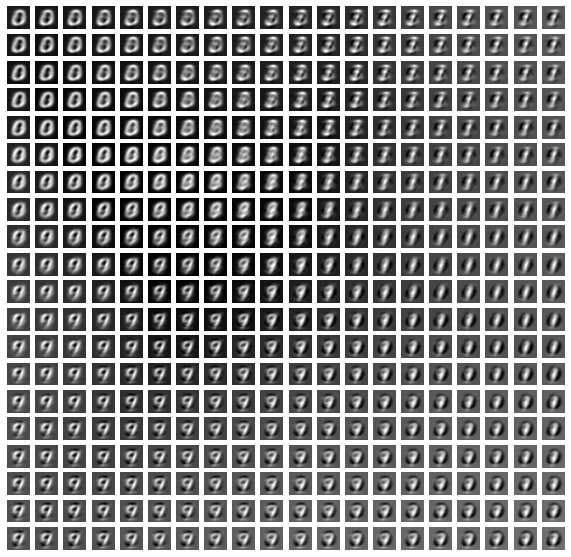

In [ ]:
xs=np.arange(0,1.0,0.05)
ys=np.arange(0,1.0,0.05)

fig, ax = plt.subplots(len(xs), len(ys), figsize=(10,10))

for j ,y in enumerate(ys):
    for i,x in enumerate(xs):
        z=model.generate(np.array([x,y]))
        z=z.reshape(28,28)
        z=to_cpu(z)
        ax[i][j].imshow(z,cmap='gray')
        ax[i][j].axis('off')
fig.show()

### BN+tanh+Adam

In [6]:
class AE3:
    def __init__(self,input_size=784,hidden_size=2,output_size=784):   

        self.layers=[Affine((input_size,),[hidden_size,1.]),
                     BatchNormalization((hidden_size,),[0.9,None,None]),
                     Tanh((hidden_size,),[]),
                     Affine((hidden_size,),[output_size,1.])]
        self.loss_layer=MSE()

        self.params,self.grads=[],[]

        for layer in self.layers:
            self.params+=layer.params
            self.grads+=layer.grads

    def predict(self,x,train_flg=False):
        for layer in self.layers:
            if isinstance(layer,BatchNormalization):
                if train_flg:
                    x=layer.forward(x,train_flg)
                else:
                    continue
            else:
                x=layer.forward(x)
        return x

    def forward(self,x,t,train_flg=True):
        y=self.predict(x,train_flg)
        loss=self.loss_layer.forward(y,t)
        return loss

    def backward(self,dout=1):
        dx=self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dx=layer.backward(dx)
        return dx

    def generate(self,x):
        y=self.layers[2].forward(x)
        y=y.reshape(28,28)
        return y

In [7]:
from common import config
config.GPU=True
from common.np import *
from common.layer_dictionary import *
from common.layers import *
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

batch_size=100
max_epoch=50
lr=0.01
iter_per_epoch=int(x_train.shape[0]/batch_size)

epoch_cnt=0

model=AE3(input_size=784,hidden_size=2,output_size=784)
optimizer=Adam(lr)

train_loss_list=[]
total_loss=0
loss_cnt=0
for epoch in range(max_epoch):
    epoch_cnt+=1
    for iter in range(iter_per_epoch):
        batch_mask=np.arange(iter*batch_size,iter*batch_size+batch_size)
        x_batch=x_train[batch_mask]

        loss=model.forward(x_batch,x_batch,train_flg=True)
        total_loss+=loss
        loss_cnt+=1

        dout=1
        model.backward(dout)
        optimizer.update(model.params,model.grads)

    average_loss=total_loss/loss_cnt
    print('loss:',average_loss)
    train_loss_list.append(average_loss)

loss: 23.69838738089526
loss: 23.405999029529855


KeyboardInterrupt: 

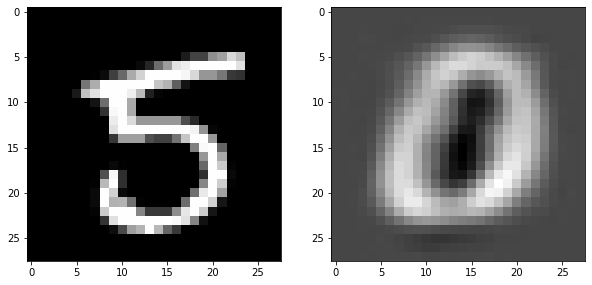

In [ ]:
import matplotlib.pyplot as plt

x=x_test[np.random.randint(len(x_test))]
y=model.predict(x,train_flg=False)
x=to_cpu(x)
y=to_cpu(y)

x=x.reshape(28,28)
y=y.reshape(28,28)

fig,ax=plt.subplots(1,2,figsize=(10,20),facecolor='w')
plt.gray()
ax[0].imshow(x)
ax[1].imshow(y)
plt.show()

### Sigmoid+Adam
[256,64,2,64,256]

In [2]:
from common import config
config.GPU=True
from common.np import *
from model.auto_encoder_dense import *
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

batch_size=100
max_epoch=20
lr=0.01
iter_per_epoch=int(x_train.shape[0]/batch_size)

epoch_cnt=0
args=(784,[256,64],2,[64,256],784,'sigmoid')
optimizer_name='adam'
optimizer_dict={'adam':Adam,'sgd':SGD,'nesterov':Nesterov}

model=AE(*args)
optimizer=optimizer_dict[optimizer_name](lr)

train_loss_list=[]
total_loss=0
loss_cnt=0
for epoch in range(max_epoch):
    epoch_cnt+=1
    for iter in range(iter_per_epoch):
        batch_mask=np.arange(iter*batch_size,iter*batch_size+batch_size)
        x_batch=x_train[batch_mask]

        loss=model.forward(x_batch,x_batch)
        total_loss+=loss
        loss_cnt+=1

        dout=1
        model.backward(dout)
        optimizer.update(model.params,model.grads)

    average_loss=total_loss/loss_cnt
    print('epoch:'+str(epoch_cnt)+' | loss:',average_loss)
    train_loss_list.append(average_loss)
    # model.save_params(ROOT_PATH+'pkl/AE_'+str(args)+'_'+optimizer_name+'_'+str(lr)+'.pkl')

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

epoch:1 | loss: 33.355499758125724
epoch:2 | loss: 32.75831846663791


KeyboardInterrupt: ignored

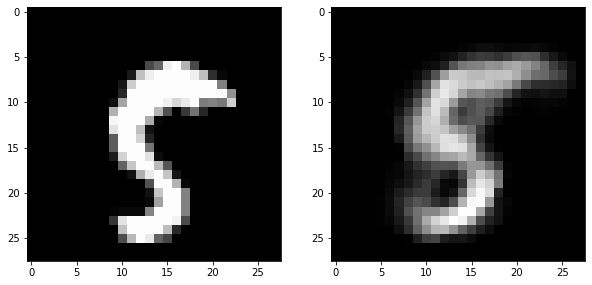

In [ ]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
model.show_predict(x_test)

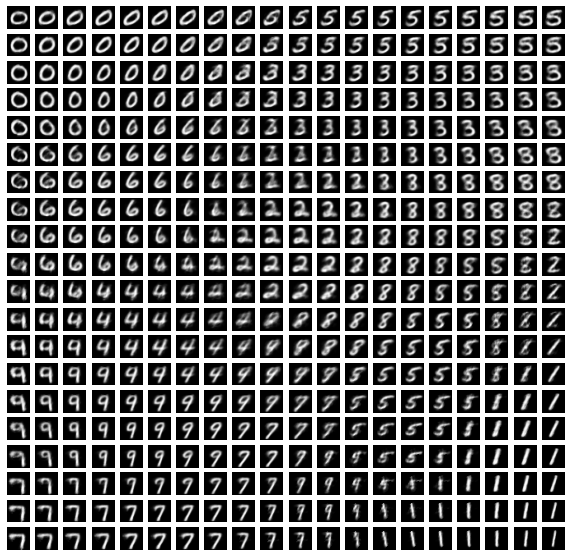

In [ ]:
model.show_generate(0,1,0.05)

### tanh+Adam
[256,64,2,64,256]

In [4]:
from common import config
config.GPU=True
from common.np import *
from model.auto_encoder_dense import *
from common.optimizer import *
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

batch_size=100
max_epoch=20
lr=0.005
iter_per_epoch=int(x_train.shape[0]/batch_size)

epoch_cnt=0
args=(784,[256,64],2,[64,256],784,'tanh')
optimizer_name='adam'
optimizer_dict={'adam':Adam,'sgd':SGD,'nesterov':Nesterov}

model=AE(*args)
optimizer=optimizer_dict[optimizer_name](lr)

train_loss_list=[]
total_loss=0
loss_cnt=0
for epoch in range(max_epoch):
    epoch_cnt+=1
    for iter in range(iter_per_epoch):
        batch_mask=np.arange(iter*batch_size,iter*batch_size+batch_size)
        x_batch=x_train[batch_mask]

        loss=model.forward(x_batch,x_batch)
        total_loss+=loss
        loss_cnt+=1

        dout=1
        model.backward(dout)
        optimizer.update(model.params,model.grads)

    average_loss=total_loss/loss_cnt
    print('epoch:'+str(epoch_cnt)+' | loss:',average_loss)
    train_loss_list.append(average_loss)
    # model.save_params(ROOT_PATH+'pkl/AE_'+str(args)+'_'+optimizer_name+'_'+str(lr)+'.pkl')

epoch:1 | loss: 35.18154128317001


KeyboardInterrupt: ignored

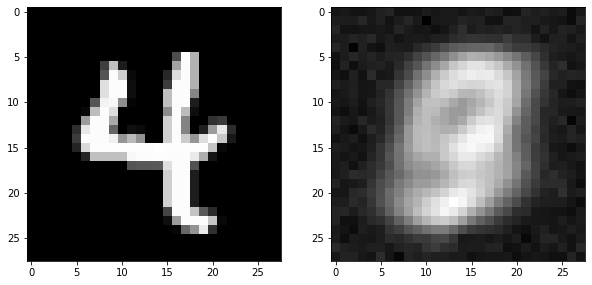

In [ ]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
model.show_predict(x_test)

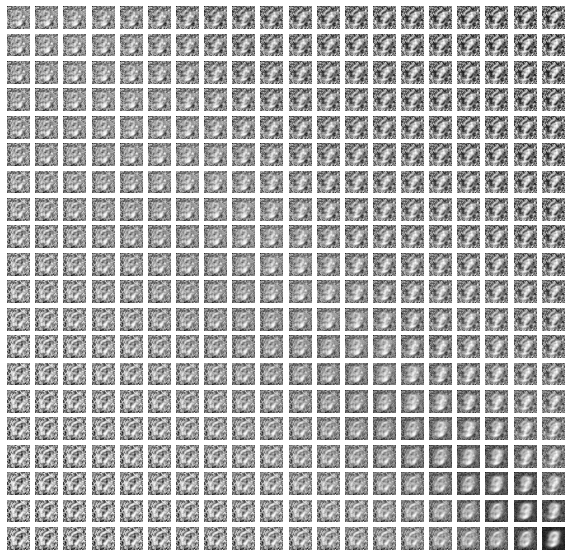

In [ ]:
model.show_generate(-1,1,0.1)

### Sigmoid+Adam
[512,256,2,256,512]

In [1]:
from common import config
config.GPU=True
from common.np import *
from model.auto_encoder_dense import *
from common.optimizer import *
from common.trainer import Trainer
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)

if GPU:
    x_train=to_gpu(x_train)
    x_test=to_gpu(x_test)

x_train=x_train.reshape(x_train.shape[0],-1)

input_size=784
hidden_list_enc=[512,256]
generate_size=2
hidden_list_dec=[256,512]
output_size=784
generate_activation='sigmoid'
activation='sigmoid'
use_batchnorm=False
show_distribution=False

lr=0.001

max_epoch=100
batch_size=100
max_grad=None
eval_interval=100

model=AE(input_size=input_size,hidden_list_enc=hidden_list_enc,generate_size=generate_size,hidden_list_dec=hidden_list_dec,output_size=output_size,generate_activation=generate_activation,activation=activation,use_batchnorm=use_batchnorm,show_distribution=show_distribution)
optimizer=Adam(lr)
trainer=Trainer(model,optimizer)

trainer.fit(x=x_train,t=x_train,max_epoch=max_epoch,batch_size=batch_size,max_grad=max_grad,eval_interval=eval_interval)

------------------------------------------------------------
                       GPU Mode (cupy)
------------------------------------------------------------

| epoch 1 |  iter 1 / 600 | time 0[s] | loss 97.54
| epoch 1 |  iter 101 / 600 | time 2[s] | loss 28.46
| epoch 1 |  iter 201 / 600 | time 5[s] | loss 25.08
| epoch 1 |  iter 301 / 600 | time 7[s] | loss 23.90
| epoch 1 |  iter 401 / 600 | time 9[s] | loss 23.63
| epoch 1 |  iter 501 / 600 | time 12[s] | loss 22.45
| epoch 2 |  iter 1 / 600 | time 14[s] | loss 21.74
| epoch 2 |  iter 101 / 600 | time 17[s] | loss 21.69
| epoch 2 |  iter 201 / 600 | time 19[s] | loss 21.13
| epoch 2 |  iter 301 / 600 | time 22[s] | loss 21.00
| epoch 2 |  iter 401 / 600 | time 24[s] | loss 20.59
| epoch 2 |  iter 501 / 600 | time 26[s] | loss 20.31
| epoch 3 |  iter 1 / 600 | time 29[s] | loss 20.07
| epoch 3 |  iter 101 / 600 | time 31[s] | loss 19.80
| epoch 3 |  iter 201 / 600 | time 34[s] | loss 19.70
| epoch 3 |  iter 301 / 600 | time 36[s

KeyboardInterrupt: 

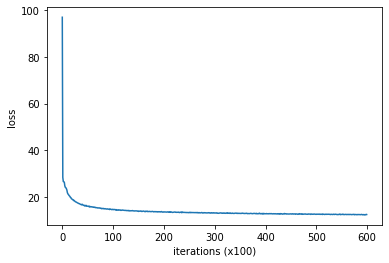

In [ ]:
trainer.plot()

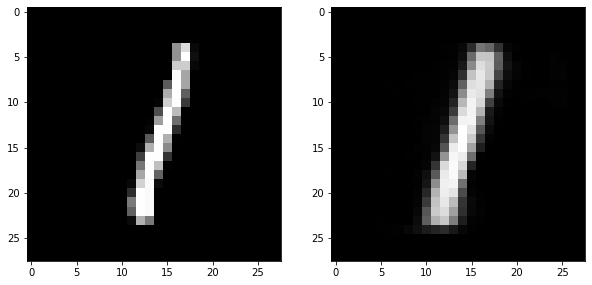

In [2]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=load_mnist(normalize=True)
model.show_predict(x_test)

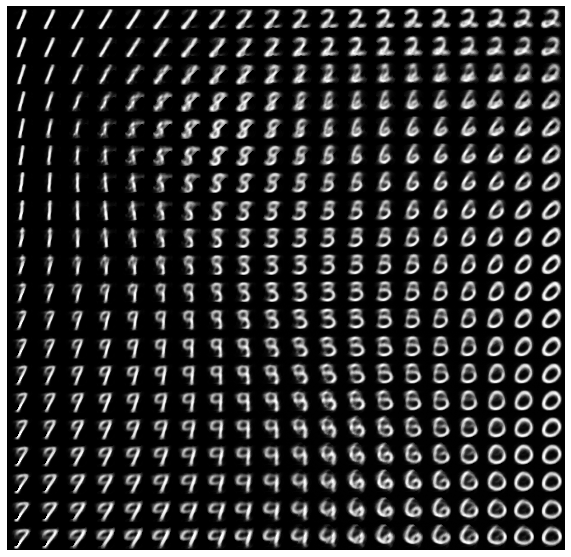

In [3]:
model.show_generate(0,1,0.05)

In [ ]:
model.save_params(ROOT_PATH+'/pkl/'+str(trainer.loss_list[-1])+'_AE_N'+str(batch_size)+str(args_model)+'_'+str(optimizer.__class__.__name__)+str(lr)+'.pkl')

In [13]:
import scipy.io

Dictionary = scipy.io.loadmat(ROOT_PATH+'/dataset/frey_rawface.mat')
print(Dictionary.keys())
print(Dictionary['ff'])

dict_keys(['__header__', '__version__', '__globals__', 'ff'])
[[ 81  85  87 ...  80  73  58]
 [136 138 139 ...  84  86  89]
 [167 165 166 ... 155 131 110]
 ...
 [152 167 172 ... 111 135 166]
 [158 178 177 ... 186 167 177]
 [164 184 183 ... 182 177 184]]


(560,)


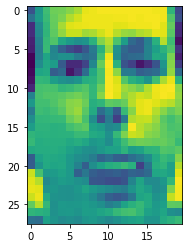

In [14]:
import numpy
import matplotlib.pyplot as plt

x=numpy.array(Dictionary['ff'])
x=x.transpose()
x=x[0]
print(x.shape)
x=x.reshape(28,20)
plt.imshow(x)
plt.show()

In [16]:
from common import config
config.GPU=True
from common.np import *
from model.auto_encoder_dense import *
from common.optimizer import *
from common.trainer import Trainer
from dataset.mnist import load_mnist
from common.util import to_cpu,to_gpu
import scipy.io

ROOT_PATH='.'
Dictionary = scipy.io.loadmat(ROOT_PATH+'/dataset/frey_rawface.mat')

if GPU:
    import numpy
    x_train=numpy.array(Dictionary['ff'])
    x_train=x_train.transpose()
    x_train=x_train/255
    x_train=to_gpu(x_train)
else:
    x_train=np.array(Dictionary['ff'])
    x_train=x_train.transpose()
    x_train=x_train/255

input_size=560
hidden_list_enc=[512,256]
generate_size=2
hidden_list_dec=[256,512]
output_size=560
generate_activation='sigmoid'
activation='sigmoid'
use_batchnorm=False
show_distribution=False

lr=0.001

max_epoch=100
batch_size=100
max_grad=None
eval_interval=100

model=AE(input_size=input_size,hidden_list_enc=hidden_list_enc,generate_size=generate_size,hidden_list_dec=hidden_list_dec,output_size=output_size,generate_activation=generate_activation,activation=activation,use_batchnorm=use_batchnorm,show_distribution=show_distribution)
optimizer=Adam(lr)
trainer=Trainer(model,optimizer)

trainer.fit(x=x_train,t=x_train,max_epoch=max_epoch,batch_size=batch_size,max_grad=max_grad,eval_interval=eval_interval)

| epoch 1 |  iter 1 / 19 | time 0[s] | loss 15.20
| epoch 2 |  iter 1 / 19 | time 0[s] | loss 4.47
| epoch 3 |  iter 1 / 19 | time 1[s] | loss 3.34
| epoch 4 |  iter 1 / 19 | time 1[s] | loss 3.27
| epoch 5 |  iter 1 / 19 | time 2[s] | loss 3.24
| epoch 6 |  iter 1 / 19 | time 2[s] | loss 3.23
| epoch 7 |  iter 1 / 19 | time 2[s] | loss 3.08
| epoch 8 |  iter 1 / 19 | time 3[s] | loss 2.86
| epoch 9 |  iter 1 / 19 | time 3[s] | loss 2.73
| epoch 10 |  iter 1 / 19 | time 4[s] | loss 2.67
| epoch 11 |  iter 1 / 19 | time 4[s] | loss 2.66
| epoch 12 |  iter 1 / 19 | time 4[s] | loss 2.60
| epoch 13 |  iter 1 / 19 | time 5[s] | loss 2.60
| epoch 14 |  iter 1 / 19 | time 5[s] | loss 2.58
| epoch 15 |  iter 1 / 19 | time 6[s] | loss 2.56
| epoch 16 |  iter 1 / 19 | time 6[s] | loss 2.52
| epoch 17 |  iter 1 / 19 | time 7[s] | loss 2.49
| epoch 18 |  iter 1 / 19 | time 7[s] | loss 2.46
| epoch 19 |  iter 1 / 19 | time 7[s] | loss 2.43
| epoch 20 |  iter 1 / 19 | time 8[s] | loss 2.40
| epoch 

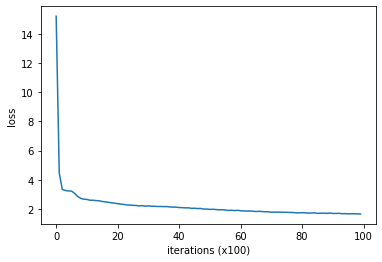

In [17]:
trainer.plot()

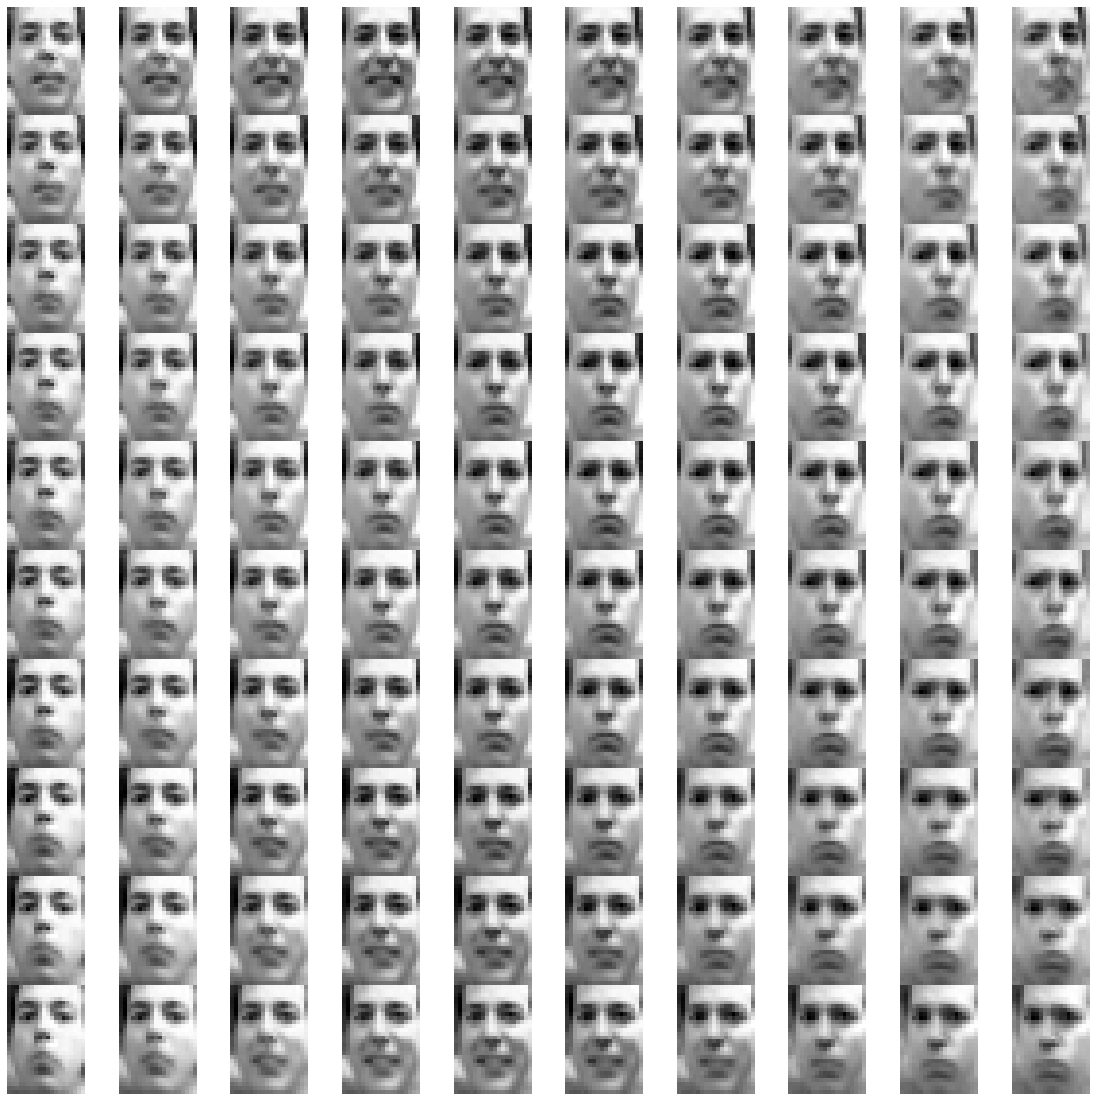

In [18]:
model.show_generate(0,1,0.1,(28,20),(20,20))

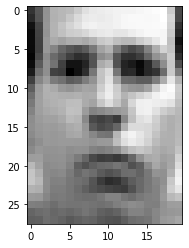

In [20]:
x=np.array([0.6,0.5])
y=model.generate(x,(28,20))
y=to_cpu(y)
plt.imshow(y,cmap='gray')
plt.show()